# This notebook uses Python 3

In [1]:
%matplotlib inline

from pyIHACRES import ihacres_funcs
from pyIHACRES.Network import Network
from pyIHACRES.Network import StreamNode, DamNode
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

In [2]:
climate_data = pd.read_table('Murrindindi.dat', index_col=0, dayfirst=True, parse_dates=True)
climate_data.rename(columns={'P': 'Murrindindi_rain', 'E': 'Murrindindi_evap', 'Q': 'streamflow'}, inplace=True)

In [3]:
net = Network.load_network('murrin_network.yml', first_node='Murrindindi')

hist_flows = climate_data['streamflow'].values
ext_data = np.zeros(len(climate_data['Murrindindi_rain']), dtype=[('Murrindindi_irrig', float), ])

In [4]:
target_node = net.network['Murrindindi']
timesteps = len(climate_data)
for ts_idx in range(timesteps):       
    target_node.run(ts_idx, climate_data, ext_data)
# End for

In [5]:
from scipy import optimize
from sklearn.metrics import r2_score, mean_squared_error


level_store = []
metric_score = []
score = -1e6

def obj_func(x_val, net, climate_data, ext_data, obs):
    
    d, d2, e, f, scoef, alpha, a, b = x_val
    
    net.reset()
    target_node = net.network['Murrindindi']
    target_node.set_calib_params((d, d2, e, f), scoef, alpha, a, b)

    timesteps = len(climate_data)
    for ts_idx in range(timesteps):       
        target_node.run(ts_idx, climate_data, ext_data)
    # End for

#     metric_mse = mean_squared_error(obs, target_node._outflow)
#     metric_rmse = np.sqrt(metric_mse)
    # metric_r2 = r2_score(obs, target_node._outflow, sample_weight=None, multioutput='uniform_average')
    metric_nse = np.sum((obs - target_node._outflow)**2) / np.sum((obs - np.mean(obs))**2)
    
    metric = metric_nse
    
    global score
    global metric_score
    if metric > score:
        global level_store
        level_store.append(target_node._outflow[:])
        score = metric
    # End if
    metric_score.append(score)
    
    return metric
# End obj_func()
    

def calib(x):
    
    d = (100.0, 550.0)
    d2 = (1.5, 20.0)
    e = (0.8, 1.1)
    f = (0.2, 1.3)
    scoef = (0.0, 3.0)
    alpha = (0.01, 0.9)
    a = (1.0, 100.0)
    b = (0.01, 2.0)
    
    bnds = [d, d2, e, f, scoef, alpha, a, b]
    
    res = optimize.minimize(obj_func, x, method='L-BFGS-B', bounds=bnds, 
                            args=(net, climate_data, ext_data, hist_flows, ),)
    return res
# End calib()

# initial node vals
# d, d2, e, f, scoef, alpha, a, b
x_0 = [150, 2.0, 1.0, 0.78, 2.0, 0.5, 54.352, 0.05]
res = calib(x_0)

In [6]:
res

      fun: 0.5533939485034941
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.22044605e-08,  1.28388300e-02, -8.45936765e-02, -1.56158864e-01,
        0.00000000e+00, -2.23106422e-02,  3.11861648e-05, -8.11851697e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 279
      nit: 13
   status: 0
  success: True
        x: array([1.49999690e+02, 1.50757257e+00, 8.07120871e-01, 1.30000000e+00,
       2.00000000e+00, 3.38106924e-02, 5.43474588e+01, 1.67458656e-02])

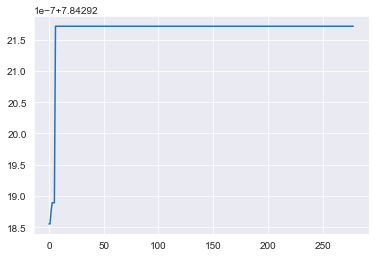

In [7]:
plt.plot(metric_score);

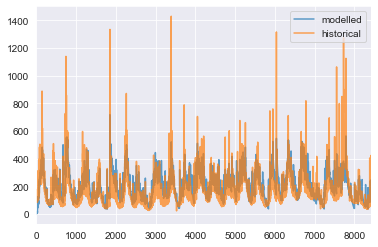

In [8]:
comparison = {
    'modelled': net.network['Murrindindi']._outflow,
    'historical': hist_flows
}

dataset = pd.DataFrame(comparison)
ax = dataset.plot(alpha=0.7);

In [9]:
d, d2, e, f, scoef, alpha, a, b = res.x

In [10]:
res.x

array([1.49999690e+02, 1.50757257e+00, 8.07120871e-01, 1.30000000e+00,
       2.00000000e+00, 3.38106924e-02, 5.43474588e+01, 1.67458656e-02])

In [11]:
net = Network.load_network('murrin_network.yml', first_node='Murrindindi')

In [12]:
net.reset()
target_node = net.network['Murrindindi']
target_node.set_calib_params((d, d2, e, f), scoef, alpha, a, b)

ext_data['Murrindindi_irrig'] = 0.0
timesteps = len(climate_data)
for ts_idx in range(timesteps):
    target_node.run(ts_idx, climate_data, ext_data)
# End for

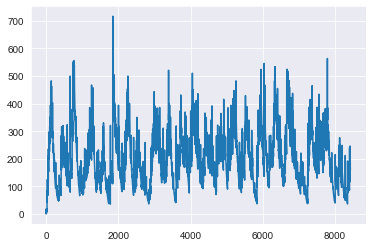

In [13]:
plt.plot(target_node._outflow);

In [14]:
import pickle

In [15]:
with open('murrin_model.pkl', 'wb') as out:
    pickle.dump(net, out)

In [16]:
with open('murrin_model.pkl', 'rb') as in_file:
    murrin = pickle.load(in_file)
# End with

node = murrin.network['Murrindindi']